# Comparison between ICA and sparse coding

In [1]:
from __future__ import division
import numpy as np
from numpy.linalg import svd,norm,pinv,eig,inv
from sklearn.feature_extraction import image
from h5py import File
from scipy.stats import entropy

from models import ica, sc

import evaluate_degeneracy_controls as dgcs
reload(dgcs)

from utils import tile_raster_images as tri

import matplotlib as mpl
import matplotlib.pyplot as plt
# Enable inline plotting
%matplotlib inline
# Set some default plotting parameters
mpl.rcParams['image.aspect'] = 'auto'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'gray'
mpl.rcParams['figure.figsize'] = (6, 6)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize']  = 20
mpl.rcParams['legend.fontsize'] = 20

Using gpu device 0: Tesla K40c (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


# Helper functions

In [2]:
def load_data(filename, key, patch_size, total_samples):
    with File(filename,'r') as f:
        ims = f[key].value
    rng = np.random.RandomState(1234)
    patches = image.PatchExtractor(patch_size=(patch_size, patch_size),\
                               max_patches=total_samples//ims.shape[0],
                               random_state=rng).transform(ims)
    return patches.reshape((patches.shape[0],patch_size**2)).T 

def decorrelate(X):
    d, u = eig(np.cov(X))
    K = np.sqrt(inv(np.diag(d))).dot(u.T)
    X_zca = u.dot(K).dot(X)
    return X_zca

def dist_identity(A,B):
    P = A.dot(B.T)
    P_ = np.zeros_like(P)
    max_idx = np.argmax(abs(P),1)
    P_[np.arange(P.shape[0]),max_idx]=1
    idx = np.argsort(max_idx)
    P_ = P_[idx]
    P = P[idx]
    return P,P_,norm(P_-np.eye(P.shape[0])),max_idx 

def ica_sparsity(W,x):
    return np.log(np.cosh(W.dot(x))).sum(axis=0).mean()

def sc_sparsity(z):
    return abs(z).sum(axis=0).mean()

def kl(a,b):
    return entropy(a,b)

# Generate toy data 

In [ ]:
patch_size = 8
total_samples = 50000
rng = np.random.RandomState(1234)
overcompleteness = 2
dim_input = patch_size**2
dim_sparse = dim_input*overcompleteness
initial_conditions = ['random']
degeneracy_control = ['L4']
k = 20

#generate dictionary
W, _ = dgcs.evaluate_dgcs(initial_conditions, degeneracy_control,
                             dim_sparse, dim_input)
W = np.squeeze(W)
A = pinv(W)

#generate sources
S = rng.laplace(0,1e3,size=(dim_sparse,total_samples))

if K is not None:
    for ii in range(total_samples):
        zero = rng.permutation(dim_sparse)[:dim_sparse-k]
        S[zero, ii] = 0.
S /= S.std(axis=-1,keepdims=True)

#generate data
X = A.dot(S)

#preprocess data
X_mean = X.mean(axis=-1, keepdims=True)
X -= X_mean
X_zca = decorrelate(X)

Inspect source distribution

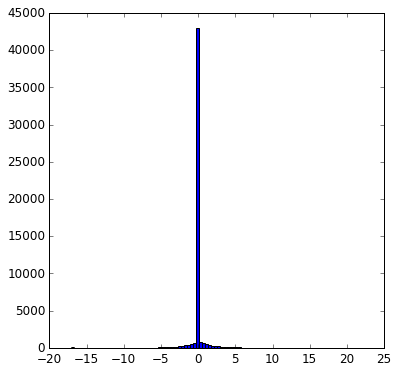

In [8]:
_ = plt.hist(S[0],100)

# Sparse coding

In [10]:
lambd = 1.
sc_model = sc.SparseCoding(n_mixtures=dim_input,
                           n_sources=dim_sparse,
                           lambd=lambd)

Random seed: 65048
Overcomplete SC


In [ ]:
sc_model.fit(X_zca)

# ICA

In [12]:
degeneracy_control = 'Lp'
p=2
lambd = 2.
ica_model = ica.ICA(n_mixtures=dim_input,n_sources=dim_sparse,lambd=lambd,
                degeneracy=degeneracy_control,p=p)

Random seed: 60548
Overcomplete ICA
Degeneracy control: Lp


In [ ]:
ica_model.fit(X_zca)

# Plotting functions

In [31]:
def plot_bases(bases,figsize=None):
    """Plots a basis set
    
    Parameters:
    ----------
    bases : ndarray
           Set of bases.
           Dimension: n_atoms X n_dims
    figname: string, optional
           Name of the figure
    """
    n_pixels = int(np.sqrt(bases.shape[1]))
    n_bases  = int(np.sqrt(bases.shape[0]))
    if figsize is None:
        fig = plt.figure()
    else:
        fig = plt.figure(figsize=figsize)
    fig.clf()
    ax = plt.axes()
    im = tri(bases,(n_pixels,n_pixels),(n_bases,n_bases),
                (2,2), scale_rows_to_unit_interval=False,
                output_pixel_vals=False)
    ax.imshow(im)
    ax.set_axis_off()
    plt.show()
    
def plot_angleHist(angles,labels,density=True,ax=None):
    if ax is None:
        fig = plt.figure('angle_hist',figsize=(4,4))
        fig.clf()
        ax = plt.axes([.15,.1,.8,.8])
    col = np.linspace(0,1,len(labels))
    for i in xrange(len(labels)):
        h,b = np.histogram(angles[i],np.arange(0,91))
        if density:
             h= h/np.sum(h)
        ax.plot(b[:-1],h,drawstyle='steps',color=plt.cm.viridis(col[i]),lw=1.5,label=labels[i])
    ax.set_yscale('log')
    if not density:
        ax.set_ylabel('Counts')
        ax.set_yticks([1e0,1e2,1e4])
    else:
        ax.set_ylabel('Density',labelpad=-10)
        ax.set_yticks([1e-5,1e0])
    ax.yaxis.set_minor_locator(mpl.ticker.NullLocator())
    ax.set_xlim(20,90)
    ax.legend(loc='upper left', frameon=False,ncol=1)
    ax.set_xlabel(r'$\theta$',labelpad=0)
    ax.set_xticks([20,55,90])
    plt.show()

def plot_perm(A,B,binary=True,order=True,ax=None):
    if ax is None:
        fig = plt.figure('perm_mat')
        ax = fig.add_subplot(111)
    P = A.dot(B.T)
    P_ = np.zeros_like(P)
    if order:
        max_idx = np.argmax(abs(P),1)
        idx = np.argsort(max_idx)
    else:
        idx = np.arange(P.shape[0])
    if binary:
        P_[np.arange(P.shape[0]),max_idx]=1
        im = ax.imshow(P_[idx])
    else:
        im = ax.imshow(P[idx])
    return im

def plot_results(ica_bases,sc_bases,W):
    W_angles = dgcs.compute_angles(W)
    ica_angles = dgcs.compute_angles(ica_bases)
    sc_angles = dgcs.compute_angles(sc_bases)

    fig = plt.figure(figsize=(12,4))
    P1, P_ica, d_ica, _  = dist_identity(ica_bases,W)
    ax1 = fig.add_subplot(131)
    im = ax1.imshow(P1)
    ax1.set_title(r'ICA; $||ord(P)-I||_2$=%.2f'%d_ica)

    P2, P_sc, d_sc, _  = dist_identity(sc_bases,W)
    ax2 = fig.add_subplot(132)
    im = ax2.imshow(P2)
    ax2.set_title(r'SC; $||ord(P)-I||_2$=%.2f'%d_sc)

    ax3 = fig.add_subplot(133)
    kl_ica = kl(ica_angles,W_angles)
    kl_sc = kl(sc_angles,W_angles)
    plot_angleHist([sc_angles,ica_angles,W_angles],['sc; kld=%.5f'%kl_sc,'ica; kld=%.5f'%kl_ica,'original'],ax=ax3)

# Results

## 1) Sparse coding with different lambdas on L4 data

In [ ]:
lambd = [.001,.01,.1,1.,10]
angles = [dgcs.compute_angles(W)]
sc_models = []

for i in xrange(len(lambd)):
    sc_models.append(sc.SparseCoding(n_mixtures=dim_input,
                           n_sources=dim_sparse,
                           lambd=lambd[i]))
    sc_models[i].fit(X_zca)
    angles.append(dgcs.compute_angles(sc_models[i].components_))

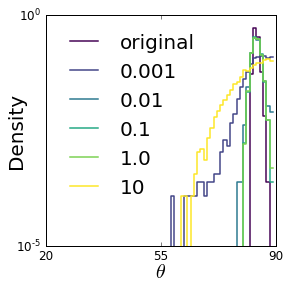

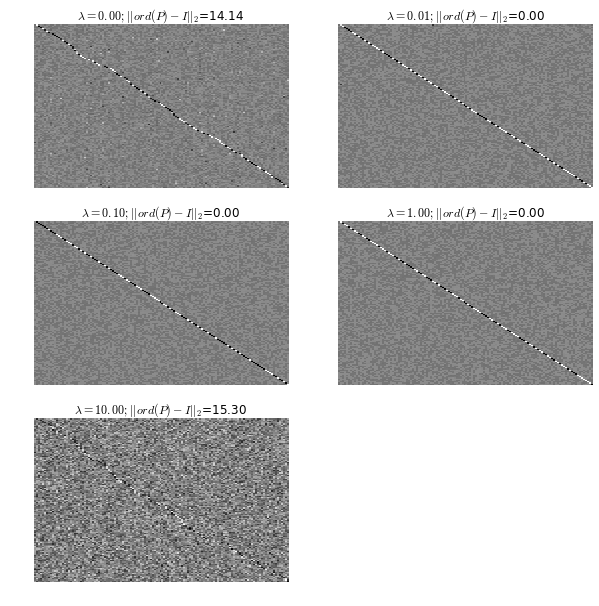

In [34]:
plot_angleHist(angles,['original']+lambd)
fig = plt.figure(figsize=(10,10))
for i in xrange(len(lambd)):
    ax = fig.add_subplot(3,2,i+1)
    P,_,d,_ = dist_identity(sc_models[i].components_,W)
    ax.set_title(r'$\lambda=%.2f; ||ord(P)-I||_2$=%.2f'%(lambd[i],d))
    im = plot_perm(sc_models[i].components_,W,ax=ax,binary=False)
    ax.set_axis_off()

## 2) Sparse coding ICA comparison

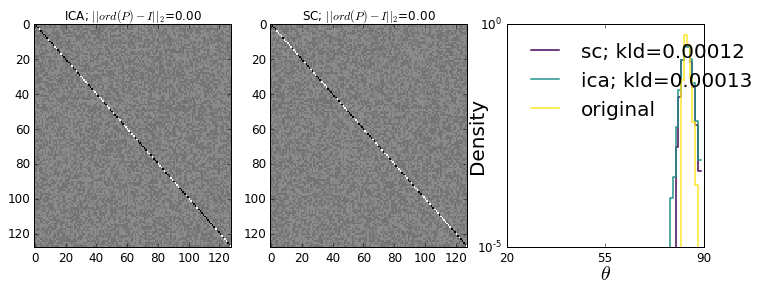

In [20]:
sc_bases = sc_model.components_
ica_bases = ica_model.components_
plot_results(ica_bases,sc_bases,W)